In [ ]:
TEST_PATH = "/content/drive/MyDrive/Projects/DS201/data/data_for_gnn/test.npz"
TRAIN_PATH = "/content/drive/MyDrive/Projects/DS201/data/data_for_gnn/train.npz"
VAL_PATH = "/content/drive/MyDrive/Projects/DS201/data/data_for_gnn/val.npz"

In [ ]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import os.path as osp
from tqdm import tqdm
from ast import literal_eval
from torch_geometric.data import Dataset, Data

In [ ]:
"""
Yêu cầu data: Ví dụ x có 100 node, mỗi node có 3 features.
                    y có 100 label cho mỗi node
x: shape(100, 3)
y: shape(100)
edge_index: shape(2, num_edges)

Ví dụ:
  x: tensor[
    [fea_1, fea_2, fea_3],
    ...
    <100 mảng>
    ...
  ]
  y: tensor[3, 52, 2, ...<100 label>..., 3]
  edge_index: tensor[
    [0, 0, 1, 2, 3, 1],
    [1, 2, 0, 0, 1, 3]
  ]
  > nghĩa là node 0 kết nối với 1 và 2 và node 3 kết nối với 1
  > (ở đây chỉ có kết nối 1 chiều nên sẽ 2 mảng sẽ có số phần tử gấp đôi node liên kết)
"""

'\nYêu cầu data: Ví dụ x có 100 node, mỗi node có 3 features.\n                    y có 100 label cho mỗi node\nx: shape(100, 3)\ny: shape(100)\nedge_index: shape(2, num_edges)\n\nVí dụ:\n  x: tensor[\n    [fea_1, fea_2, fea_3],\n    ...\n    <100 mảng>\n    ...\n  ]\n  y: tensor[3, 52, 2, ...<100 label>..., 3]\n  edge_index: tensor[\n    [0, 0, 1, 2, 3, 1],\n    [1, 2, 0, 0, 1, 3]\n  ]\n  > nghĩa là node 0 kết nối với 1 và 2 và node 3 kết nối với 1\n  > (ở đây chỉ có kết nối 1 chiều nên sẽ 2 mảng sẽ có số phần tử gấp đôi node liên kết)\n'

# tạo node các đoạn đường, và tạo edge_index

In [ ]:
class RoadNode():
  def __init__(self, segment_id, streetName, connected_segment_ids, speedLimit, frc):
    self.segment_id = int(segment_id)
    self.streetName = streetName
    self.connected_segment_ids = literal_eval(connected_segment_ids)
    self.speedLimit = int(speedLimit)
    self.frc = frc
    self.unique_id = None # unique_id to make edge_index
    self.history = None
    self.cur_val = None

  def get_unique_id(self, map_id: dict):
    self.unique_id = map_id[self.segment_id]

  def get_history(self, history_dict: dict):
    self.history = history_dict[self.segment_id]
    self.cur_val = self.history[-1]


In [ ]:
import pandas as pd

df_road_shape = pd.read_csv("/content/drive/MyDrive/Projects/DS201/data/q1_road_shape.csv")
df_traffic = pd.read_csv("/content/drive/MyDrive/Projects/DS201/data/q1_traffic.csv")

In [ ]:
df_traffic["density"] = df_traffic["segmentProbeCounts"] / df_traffic["distance"]
df_traffic["time"] = df_traffic["time"].apply(lambda x: x[:x.index("-") - 1])
df_traffic['datetime'] = pd.to_datetime(df_traffic['date'] + ' ' + df_traffic['time'])
df_traffic.sort_values(by='datetime', inplace=True)

In [ ]:
# lấy dữ liệu quá khứ của từng node
history_density = {}
for segment_id in df_road_shape.segment_id:
    df_tmp = df_traffic[df_traffic["segment_id"] == segment_id]
    history_density[segment_id] = df_tmp["density"].values.tolist()

In [ ]:
history_density = {str(k): v for k, v in history_density.items()}

In [ ]:
history_density = {int(k): v for k, v in history_density.items()}

In [ ]:
df_traffic = df_traffic[["segment_id", "speedLimit", "frc"]]
df_traffic.drop_duplicates(inplace=True)
df_road_node = pd.merge(df_road_shape[["segment_id", "streetName", "connected_segment_ids"]], df_traffic[["segment_id", "speedLimit", "frc"]], on="segment_id", how="left")
df_road_node.sample()

,segment_id,streetName,connected_segment_ids,speedLimit,frc
497,-17040018844625,Đường Nguyễn Cư Trinh,"[-17040019883003, -17040019260409, -1704001884...",50,connecting road


In [ ]:
road_nodes = [RoadNode(row["segment_id"], row["streetName"], row["connected_segment_ids"], row["speedLimit"], row["frc"]) for _, row in df_road_node.iterrows()]

In [ ]:
map_id = {}
for idx, segment_id in enumerate(df_road_node["segment_id"].values):
    map_id[segment_id] = idx

for i in range(len(road_nodes)):
    road_nodes[i].get_unique_id(map_id)

In [ ]:
for i in range(len(road_nodes)):
    road_nodes[i].get_history(history_density)

In [ ]:
id_2_segment_id = {v: k for k, v in map_id.items()}

In [ ]:
arr_1, arr_2 = [], []
for i in tqdm(range(len(road_nodes))):
    if i in arr_1 or i in arr_2:
        continue
    for connected_segment_id in road_nodes[i].connected_segment_ids:
        if map_id[connected_segment_id] in arr_1 or map_id[connected_segment_id] in arr_2:
            continue
        if road_nodes[i].unique_id != map_id[connected_segment_id]:
            arr_1.append(road_nodes[i].unique_id)
            arr_2.append(map_id[connected_segment_id])

            arr_1.append(map_id[connected_segment_id])
            arr_2.append(road_nodes[i].unique_id)

100%|██████████| 4540/4540 [00:01<00:00, 3632.25it/s]


In [ ]:
edge_index = torch.tensor([arr_1, arr_2])

In [ ]:
edge_index

tensor([[   0,   21,    0,  ..., 4511, 4470, 4517],
        [  21,    0,   54,  ..., 4470, 4517, 4470]])

In [ ]:
# x: tensor[
#     [fea_1, fea_2, fea_3],
#     ...
#     <100 mảng>
#     ...
#   ]
#   y: tensor[3, 52, 2, ...<100 label>..., 3]

# TrafficDataset

In [ ]:
import torch
def create_sequences(data, seq_size):
    x, y = [], []

    for i in range(len(data) - seq_size):
        seq_x = data[i:i + seq_size]
        seq_y = data[i + seq_size]
        x.append(seq_x)
        y.append(seq_y)

    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    return x, y

In [ ]:
x, y = create_sequences(node.history, 5)

In [ ]:
data_nodes = []
for node in tqdm(road_nodes):
    x, y = create_sequences(node.history, 5)
    edge_index = torch.tensor([[node.segment_id, neighbor] for neighbor in node.connected_segment_ids], dtype=torch.long).t().contiguous()
    data_nodes.append(Data(x=x, y=y, edge_index=edge_index))

100%|██████████| 4540/4540 [00:02<00:00, 1895.27it/s]


In [ ]:
from torch_geometric.data import DataLoader
dataloader = DataLoader(data_nodes, batch_size=1)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
data_nodes[0]

Data(x=[475, 5], edge_index=[2, 12], y=[475])

In [ ]:
batch = next(iter(dataloader))
batch

DataBatch(x=[475, 5], edge_index=[2, 12], y=[475], batch=[475], ptr=[2])

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader, Batch
from torch.nn import Sequential as Seq, Linear, ReLU

class GNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, output_size)
        self.fc = nn.Linear(output_size, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = torch_geometric.nn.global_add_pool(x, batch)

        x = self.fc(x)
        return x

input_size = 5
hidden_size = 16
output_size = 8

# Instantiate the model
model = GNNModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

In [ ]:
model(batch)

In [ ]:
def train(model, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in val_loader:
                out = model(batch)
                val_loss += loss_fn(out, batch.y)

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}: Train loss: {loss:.4f}, Val loss: {val_loss:.4f}")

In [ ]:
# #biểu đồ độ fit của mô hình dự đoán so với ground truth của đoạn đường -17040021066708
predictions = model.predict(X_test)
#predictions_original = scaler.inverse_transform(predictions)
#y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Ground Truth', marker='o')
plt.plot(predictions, label='Predictions', marker='o')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Ground Truth vs Predictions on Test Data')
plt.legend()
plt.show()

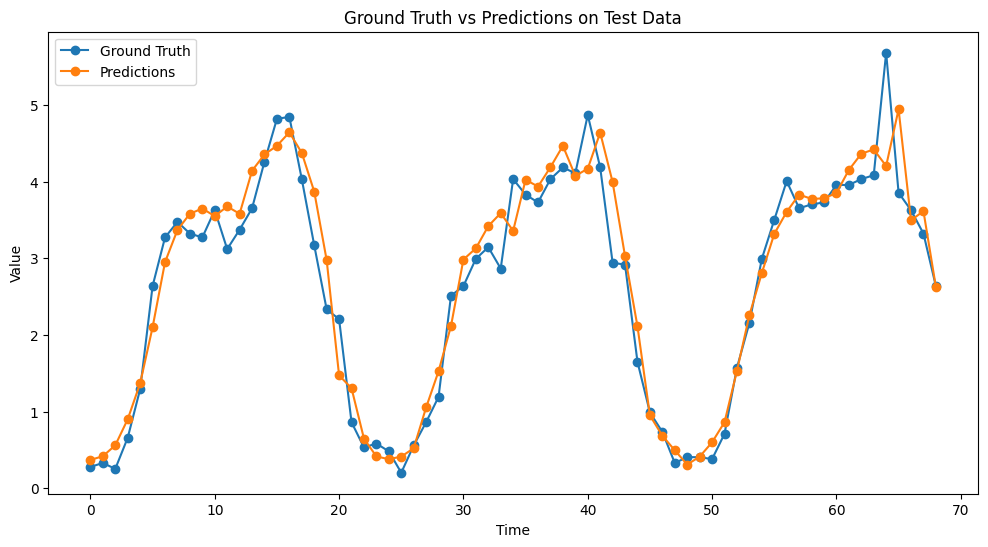